In [12]:
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import glob, os
import re
import json
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import mannwhitneyu,ttest_ind
from math import log, e

In [17]:
###READING DATA
bipolar_data = pd.read_pickle("/Users/tanjakemper/Documents/Bipolar Project/datasets/bipolar_data/bipolar_data_all_tweets.pkl", compression='infer')
bipolar_data.drop('full_text',inplace=True,axis=1)

control_data = pd.read_pickle("/Users/tanjakemper/Documents/Bipolar Project/datasets/control_data/1/control_data_all_tweets.pkl", compression='infer')
control_data.drop('full_text',inplace=True,axis=1)


In [18]:
### CONCAT DATASETS
all_data = pd.concat([control_data, bipolar_data])
all_data.sample(5, random_state=0)

,id,is_control,created_at
621922,3336339869,0,2018-08-26 18:51:30
272708,302214919,1,2015-02-22 09:55:52
1372791,526579594,1,2017-04-15 22:54:47
1697351,85221911,1,2015-09-02 04:00:48
759288,299970163,1,2016-12-29 18:34:54


In [19]:
### FILTER OUT TWEETS BEFORE 2013
all_data2013 = all_data[(all_data.created_at >= '2013-1-1 01:00:00')]

In [20]:
all_data2013 = all_data2013.set_index('created_at')
all_data2013['year'] = pd.to_datetime(all_data2013.index).year
all_data2013['month'] = pd.to_datetime(all_data2013.index).month
all_data2013['month_year'] = pd.to_datetime(all_data2013.index).to_period('M')

all_data2013.sample(5)

,id,is_control,year,month,month_year
created_at,,,,,
2018-07-22 01:10:53,881553653945036800,0,2018,7,2018-07
2017-07-21 07:09:42,1037469482,1,2017,7,2017-07
2016-05-25 18:06:09,2546312407,1,2016,5,2016-05
2019-03-04 19:25:20,899675145354260481,0,2019,3,2019-03
2016-02-23 12:13:15,103356365,0,2016,2,2016-02


In [21]:
all_data2013['date'] = pd.PeriodIndex(all_data2013.month_year, freq='M').to_timestamp()

In [22]:
all_data2013.head()

,id,is_control,year,month,month_year,date
created_at,,,,,,
2019-04-18 07:13:47,185501402,1,2019,4,2019-04,2019-04-01
2019-04-17 04:04:24,185501402,1,2019,4,2019-04,2019-04-01
2019-03-31 17:33:40,185501402,1,2019,3,2019-03,2019-03-01
2019-03-31 17:33:29,185501402,1,2019,3,2019-03,2019-03-01
2019-03-31 17:32:51,185501402,1,2019,3,2019-03,2019-03-01


In [23]:
all_data2013 = all_data2013.reset_index().set_index('id')

In [24]:
all_data2013.head()

,created_at,is_control,year,month,month_year,date
id,,,,,,
185501402,2019-04-18 07:13:47,1,2019,4,2019-04,2019-04-01
185501402,2019-04-17 04:04:24,1,2019,4,2019-04,2019-04-01
185501402,2019-03-31 17:33:40,1,2019,3,2019-03,2019-03-01
185501402,2019-03-31 17:33:29,1,2019,3,2019-03,2019-03-01
185501402,2019-03-31 17:32:51,1,2019,3,2019-03,2019-03-01


In [25]:
### DEFINE MONTHS OF POSTING PER USER
all_data2013_months = all_data2013.groupby(by='id').agg({'month_year': pd.Series.nunique})
## MERGING WITH INITIAL DATASET
all_data_merged = pd.merge(all_data2013_months, all_data2013, left_index=True, right_on='id')
all_data_merged.rename(columns={'month_year_x': 'amount_of_months'}, inplace=True)
all_data_merged.head(10)

,amount_of_months,created_at,is_control,year,month,month_year_y,date
id,,,,,,,
1000083678,66,2019-05-09 06:54:06,1,2019,5,2019-05,2019-05-01
1000083678,66,2019-05-09 06:53:24,1,2019,5,2019-05,2019-05-01
1000083678,66,2019-05-09 02:33:51,1,2019,5,2019-05,2019-05-01
1000083678,66,2019-03-06 08:10:21,1,2019,3,2019-03,2019-03-01
1000083678,66,2019-03-06 02:38:18,1,2019,3,2019-03,2019-03-01
1000083678,66,2019-03-05 17:50:43,1,2019,3,2019-03,2019-03-01
1000083678,66,2019-03-05 17:34:55,1,2019,3,2019-03,2019-03-01
1000083678,66,2019-03-03 22:17:58,1,2019,3,2019-03,2019-03-01
1000083678,66,2019-03-02 08:12:15,1,2019,3,2019-03,2019-03-01


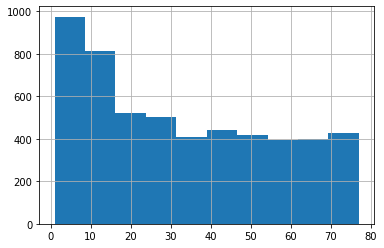

In [26]:
all_data_merged.groupby('id').first()['amount_of_months'].hist()

## AMOUNT OF POSTS PER MONTH (BIPOLAR VS CONTROL GROUP)

In [27]:
all_data_merged.reset_index().set_index('is_control')

,id,amount_of_months,created_at,year,month,month_year_y,date
is_control,,,,,,,
1,1000083678,66,2019-05-09 06:54:06,2019,5,2019-05,2019-05-01
1,1000083678,66,2019-05-09 06:53:24,2019,5,2019-05,2019-05-01
1,1000083678,66,2019-05-09 02:33:51,2019,5,2019-05,2019-05-01
1,1000083678,66,2019-03-06 08:10:21,2019,3,2019-03,2019-03-01
1,1000083678,66,2019-03-06 02:38:18,2019,3,2019-03,2019-03-01
1,1000083678,66,2019-03-05 17:50:43,2019,3,2019-03,2019-03-01
1,1000083678,66,2019-03-05 17:34:55,2019,3,2019-03,2019-03-01
1,1000083678,66,2019-03-03 22:17:58,2019,3,2019-03,2019-03-01
1,1000083678,66,2019-03-02 08:12:15,2019,3,2019-03,2019-03-01


In [28]:
bipolar_per_month = all_data_merged[(all_data_merged.is_control == 0)]
control_per_month = all_data_merged[(all_data_merged.is_control == 1)]
bipolar_per_month.head()

,amount_of_months,created_at,is_control,year,month,month_year_y,date
id,,,,,,,
10006872,8,2019-04-18 00:49:18,0,2019,4,2019-04,2019-04-01
10006872,8,2019-04-18 00:44:52,0,2019,4,2019-04,2019-04-01
10006872,8,2019-04-18 00:44:25,0,2019,4,2019-04,2019-04-01
10006872,8,2019-04-18 00:35:21,0,2019,4,2019-04,2019-04-01
10006872,8,2019-04-18 00:34:47,0,2019,4,2019-04,2019-04-01


In [29]:
bipolar_per_month = bipolar_per_month.groupby(['id', 'date', 'amount_of_months'])['created_at'].size().to_frame('posts_per_month').reset_index()
control_per_month = control_per_month.groupby(['id', 'date', 'amount_of_months'])['created_at'].size().to_frame('posts_per_month').reset_index()

control_per_month.head(10)

,id,date,amount_of_months,posts_per_month
0,1000083678,2013-09-01,66,17
1,1000083678,2013-10-01,66,32
2,1000083678,2013-11-01,66,57
3,1000083678,2013-12-01,66,45
4,1000083678,2014-01-01,66,9
5,1000083678,2014-02-01,66,53
6,1000083678,2014-03-01,66,52
7,1000083678,2014-04-01,66,14
8,1000083678,2014-05-01,66,25
9,1000083678,2014-06-01,66,6


In [30]:
# ADD MISSING MONTHS WITH 0 POSTS
fillna_bipolar = bipolar_per_month.set_index('date').groupby('id').resample('MS').asfreq()
fillna_control = control_per_month.set_index('date').groupby('id').resample('MS').asfreq()

fillna_bipolar.head()

id  amount_of_months  posts_per_month
id       date                                                   
10006872 2018-09-01  10006872               8.0            329.0
         2018-10-01  10006872               8.0            522.0
         2018-11-01  10006872               8.0            388.0
         2018-12-01  10006872               8.0            274.0
         2019-01-01  10006872               8.0            435.0

In [31]:
fillna_control.head()

id  amount_of_months  posts_per_month
id         date                                                     
1000083678 2013-09-01  1000083678              66.0             17.0
           2013-10-01  1000083678              66.0             32.0
           2013-11-01  1000083678              66.0             57.0
           2013-12-01  1000083678              66.0             45.0
           2014-01-01  1000083678              66.0              9.0

In [32]:
# DROP DUBLICATE OF ID COLUMN
fillna_bipolar.drop('id', inplace=True,axis=1)
fillna_control.drop('id', inplace=True,axis=1)
fillna_control.head()

amount_of_months  posts_per_month
id         date                                         
1000083678 2013-09-01              66.0             17.0
           2013-10-01              66.0             32.0
           2013-11-01              66.0             57.0
           2013-12-01              66.0             45.0
           2014-01-01              66.0              9.0

In [33]:
fillna_bipolar.head(100)

amount_of_months  posts_per_month
id                  date                                         
10006872            2018-09-01               8.0            329.0
                    2018-10-01               8.0            522.0
                    2018-11-01               8.0            388.0
                    2018-12-01               8.0            274.0
                    2019-01-01               8.0            435.0
                    2019-02-01               8.0            259.0
                    2019-03-01               8.0            305.0
                    2019-04-01               8.0            146.0
1001172883115335685 2018-11-01               6.0            449.0
                    2018-12-01               6.0            434.0
                    2019-01-01               6.0            452.0
                    2019-02-01               6.0            599.0
                    2019-03-01               6.0            788.0
                    2019-04-01               6.0            260.0
1001229638490906624 2018-05-01               6.0              4.0
                    2018-06-01               6.0             22.0
                    2018-07-01               6.0             27.0
                    2018-08-01               6.0              8.0
                    2018-09-01               NaN              NaN
                    2018-10-01               NaN              NaN
                    2018-11-01               6.0              1.0
                    2018-12-01               NaN              NaN
                    2019-01-01               NaN              NaN
                    2019-02-01               NaN              NaN
                    2019-03-01               6.0              1.0
1001590695822475265 2018-10-01               7.0            376.0
                    2018-11-01               7.0            198.0
                    2018-12-01               7.0            653.0
                    2019-01-01               7.0            109.0
                    2019-02-01               7.0            443.0
...                                          ...              ...
1002580574119264257 2019-02-01              11.0             39.0
                    2019-03-01              11.0              7.0
                    2019-04-01              11.0              3.0
1002665746982465537 2018-06-01              11.0            121.0
                    2018-07-01              11.0             95.0
                    2018-08-01              11.0             43.0
                    2018-09-01              11.0             53.0
                    2018-10-01              11.0             47.0
                    2018-11-01              11.0             35.0
                    2018-12-01              11.0             66.0
                    2019-01-01              11.0             53.0
                    2019-02-01              11.0             58.0
                    2019-03-01              11.0             43.0
                    2019-04-01              11.0             40.0
1003044037266493441 2018-06-01              11.0            100.0
                    2018-07-01              11.0             61.0
                    2018-08-01              11.0             61.0
                    2018-09-01              11.0             48.0
                    2018-10-01              11.0             20.0
                    2018-11-01              11.0             15.0
                    2018-12-01              11.0             31.0
                    2019-01-01              11.0             29.0
                    2019-02-01              11.0             20.0
                    2019-03-01              11.0             60.0
                    2019-04-01              11.0             35.0
1003329852437680129 2018-06-01               7.0             25.0
                    2018-07-01               7.0            225.0
                    2018-08-01               7.0             91.0
      

In [34]:
# FILL NAN WITH 0 VALUES TO POSTS COLUMN AND PREVIOUS ROW VALUE TO MONTHS COLUMN
fillna_bipolar['amount_of_months'].fillna(method='ffill', inplace=True)
fillna_control['amount_of_months'].fillna(method='ffill', inplace=True)
fillna_bipolar['posts_per_month'].fillna('0', inplace=True)
fillna_control['posts_per_month'].fillna('0', inplace=True)
fillna_bipolar.head(100)

amount_of_months posts_per_month
id                  date                                        
10006872            2018-09-01               8.0             329
                    2018-10-01               8.0             522
                    2018-11-01               8.0             388
                    2018-12-01               8.0             274
                    2019-01-01               8.0             435
                    2019-02-01               8.0             259
                    2019-03-01               8.0             305
                    2019-04-01               8.0             146
1001172883115335685 2018-11-01               6.0             449
                    2018-12-01               6.0             434
                    2019-01-01               6.0             452
                    2019-02-01               6.0             599
                    2019-03-01               6.0             788
                    2019-04-01               6.0             260
1001229638490906624 2018-05-01               6.0               4
                    2018-06-01               6.0              22
                    2018-07-01               6.0              27
                    2018-08-01               6.0               8
                    2018-09-01               6.0               0
                    2018-10-01               6.0               0
                    2018-11-01               6.0               1
                    2018-12-01               6.0               0
                    2019-01-01               6.0               0
                    2019-02-01               6.0               0
                    2019-03-01               6.0               1
1001590695822475265 2018-10-01               7.0             376
                    2018-11-01               7.0             198
                    2018-12-01               7.0             653
                    2019-01-01               7.0             109
                    2019-02-01               7.0             443
...                                          ...             ...
1002580574119264257 2019-02-01              11.0              39
                    2019-03-01              11.0               7
                    2019-04-01              11.0               3
1002665746982465537 2018-06-01              11.0             121
                    2018-07-01              11.0              95
                    2018-08-01              11.0              43
                    2018-09-01              11.0              53
                    2018-10-01              11.0              47
                    2018-11-01              11.0              35
                    2018-12-01              11.0              66
                    2019-01-01              11.0              53
                    2019-02-01              11.0              58
                    2019-03-01              11.0              43
                    2019-04-01              11.0              40
1003044037266493441 2018-06-01              11.0             100
                    2018-07-01              11.0              61
                    2018-08-01              11.0              61
                    2018-09-01              11.0              48
                    2018-10-01              11.0              20
                    2018-11-01              11.0              15
                    2018-12-01              11.0              31
                    2019-01-01              11.0              29
                    2019-02-01              11.0              20
                    2019-03-01              11.0              60
                    2019-04-01              11.0              35
1003329852437680129 2018-06-01               7.0              25
                    2018-07-01               7.0             225
                    2018-08-01               7.0              91
                    2018-09-01               7.0               0
  

In [36]:
fillna_control.head()

amount_of_months posts_per_month
id         date                                        
1000083678 2013-09-01              66.0              17
           2013-10-01              66.0              32
           2013-11-01              66.0              57
           2013-12-01              66.0              45
           2014-01-01              66.0               9

In [37]:
# CHANGE THE TYPE OF COLUMN posts_per_month TO NUMERIC
fillna_bipolar['posts_per_month'] = fillna_bipolar['posts_per_month'].astype(np.float)
fillna_control['posts_per_month'] = fillna_control['posts_per_month'].astype(np.float)

In [38]:
from scipy.stats import zscore
from scipy import stats


In [39]:
## NORMALIZE DATA WITH Z-SCORE
fillna_bipolar['posts_normalized'] = (fillna_bipolar['posts_per_month']
                        - fillna_bipolar.groupby('id')['posts_per_month'].transform(np.mean)) \
                        / fillna_bipolar.groupby('id')['posts_per_month'].transform(np.std)
fillna_control['posts_normalized'] = (fillna_control['posts_per_month']
                        - fillna_control.groupby('id')['posts_per_month'].transform(np.mean)) \
                        / fillna_control.groupby('id')['posts_per_month'].transform(np.std)

In [40]:
# FILTER USERS WITH LESS THAN 12 MONTHS
bipolar = fillna_bipolar[fillna_bipolar.amount_of_months >= 12]
control = fillna_control[fillna_control.amount_of_months >= 12]

In [41]:
bipolar

amount_of_months  posts_per_month  \
id                 date                                            
100390522          2016-02-01              39.0             61.0   
                   2016-03-01              39.0             98.0   
                   2016-04-01              39.0             97.0   
                   2016-05-01              39.0            160.0   
                   2016-06-01              39.0            166.0   
                   2016-07-01              39.0            109.0   
                   2016-08-01              39.0             48.0   
                   2016-09-01              39.0             87.0   
                   2016-10-01              39.0             89.0   
                   2016-11-01              39.0            151.0   
                   2016-12-01              39.0            194.0   
                   2017-01-01              39.0            212.0   
                   2017-02-01              39.0            159.0   
                   2017-03-01              39.0            146.0   
                   2017-04-01              39.0            136.0   
                   2017-05-01              39.0            167.0   
                   2017-06-01              39.0            243.0   
                   2017-07-01              39.0            111.0   
                   2017-08-01              39.0            106.0   
                   2017-09-01              39.0             75.0   
                   2017-10-01              39.0             82.0   
                   2017-11-01              39.0             25.0   
                   2017-12-01              39.0              4.0   
                   2018-01-01              39.0             55.0   
                   2018-02-01              39.0             89.0   
                   2018-03-01              39.0             40.0   
                   2018-04-01              39.0             50.0   
                   2018-05-01              39.0             28.0   
                   2018-06-01              39.0             18.0   
                   2018-07-01              39.0             13.0   
...                                         ...              ...   
998243312          2017-11-01              61.0             64.0   
                   2017-12-01              61.0             98.0   
                   2018-01-01              61.0             84.0   
                   2018-02-01              61.0             57.0   
                   2018-03-01              61.0             71.0   
                   2018-04-01              61.0             84.0   
                   2018-05-01              61.0             79.0   
                   2018-06-01              61.0            105.0   
                   2018-07-01              61.0            115.0   
                   2018-08-01              61.0            183.0   
                   2018-09-01              61.0            149.0   
                   2018-10-01              61.0             88.0   
                   2018-11-01              61.0             57.0   
                   2018-12-01              61.0             47.0   
                   2019-01-01              61.0             62.0   
                   2019-02-01              61.0             79.0   
                   2019-03-01              61.0             39.0   
                   2019-04-01              61.0              6.0   
999155031755571201 2018-05-01              12.0             25.0   
                   2018-06-01              12.0             48.0   
                   2018-07-01              12.0            120.0   
                   2018-08-01              12.0            113.0   
                   2018-09-01              12.0             84.0   
                   2018-10-01              12.0             77.0   
                   2018-11-01              12.0             57.0   
                   2018-12-01              12.0             29.0   
                   

In [42]:
def volatility(s):
    """Computes root mean square succesive difference of series s."""
    return(np.nanmean((np.array(s[1:]) - np.array(s[:-1]))**2)**(1/2))

In [43]:
## COMPUTATE VOLATILITY BIPOLAR
volatility_activity_bipolar = bipolar.groupby(['id', 'amount_of_months'])['posts_normalized'].aggregate(
    {'volatility':volatility})
volatility_activity_bipolar

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



,,volatility
id,amount_of_months,
100390522,39.0,0.600349
100630850,55.0,1.037398
1021257140,44.0,0.815935
102253257,59.0,0.585225
1024631256,13.0,1.436284
1024914678,32.0,0.757532
1025511452,30.0,1.014890
1027684272,28.0,0.668627
1030640928,37.0,0.947053


In [44]:
# COMPUTATE VOLATILITY CONTROL
volatility_activity_control = control.groupby(['id', 'amount_of_months'])['posts_normalized'].aggregate(
    {'volatility':volatility})
volatility_activity_control

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



,,volatility
id,amount_of_months,
1000083678,66.0,0.964536
100013511,49.0,1.190734
1004182135,48.0,0.593461
1005110942,23.0,1.470148
100616320,43.0,1.118492
100661816,27.0,1.034531
1007006312,75.0,1.072598
1007125950,30.0,1.158452
100821800,63.0,0.402789


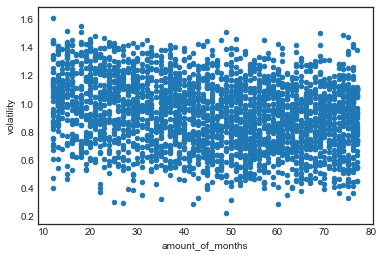

In [46]:
volatility_activity_control.reset_index().set_index('id').plot(x='amount_of_months', y='volatility',kind='scatter')

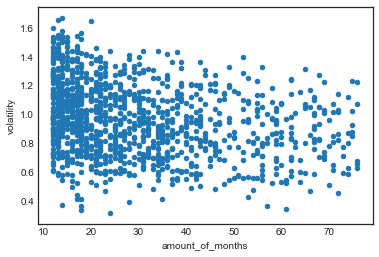

In [47]:
volatility_activity_bipolar.reset_index().set_index('id').plot(x='amount_of_months', y='volatility',kind='scatter')

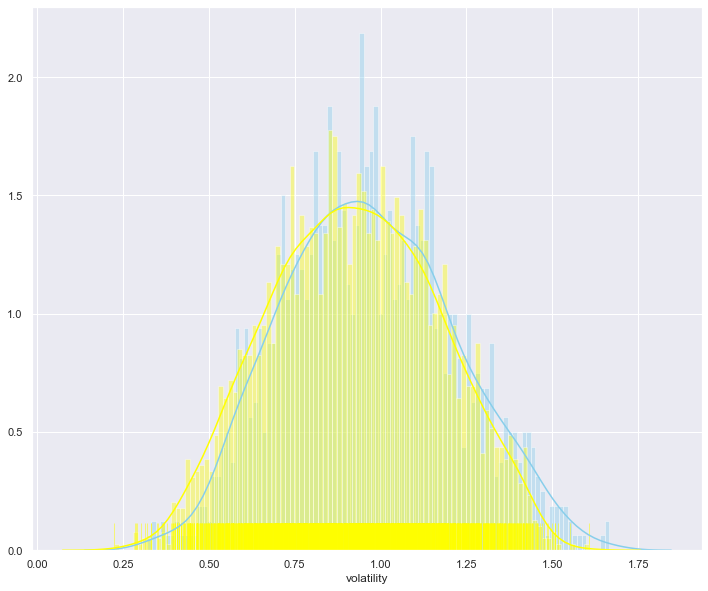

In [55]:
sns.distplot(volatility_activity_bipolar['volatility'], color="skyblue", bins = 100, label="Bipolar Group")
sns.distplot(volatility_activity_control['volatility'] , color="yellow", bins = 100, label="Control Group", rug = True, rug_kws={"alpha":0.5})
sns.set(rc={'figure.figsize':(12, 10)})

In [53]:
np.mean(volatility_activity_bipolar)

volatility    0.966729
dtype: float64

In [54]:
np.mean(volatility_activity_control)

volatility    0.923236
dtype: float64

In [56]:
from scipy.stats import mannwhitneyu,ttest_ind
ttest_ind(volatility_activity_bipolar,volatility_activity_control)

Ttest_indResult(statistic=array([5.13668407]), pvalue=array([2.92986847e-07]))

In [58]:
from scipy.stats import ks_2samp
mannwhitneyu(volatility_activity_bipolar,volatility_activity_control)

MannwhitneyuResult(statistic=1515966.0, pvalue=3.61236468057398e-06)